In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import datetime

import pandas as pd
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import collections

from sklearn.model_selection import KFold

# What we're doing

For many years now, I've been very interested in two related, but different questions:
1. How to _apply_ Machine Learning to Economics by integrating ML into the usual econometric pipeline?
2. What do the ML algorithms themselves teach us about how economies work.

Recently, however, there seems to be a wave of interest (especially coming from the work coming from Stanford University) in these questions. This notebook is about the point 1. In particular, about the problem of estimating causal inference. (Unfortunately, point 2 seems to be still far from being considered.)

We are going to replicate the methodology (and hopefully results) of a recent paper in which the problem of causal inference is seen from the lens of the problem of ''matrix completion'' from the machine learning literature. I found out about this paper thanks to my dear friend Sid Ravinutala.

Since I became aware of this paper, I've become increasingly interested in **Susan Athey**'s work, who's precisely preaching about the importance of using ML in economics. Let's see what she did here...

# Set up of the problem

The paper we want to reproduce is: 

''Matrix Completion Methods for Causal Panel Data Models''
by Susan Athey, Mohsen Bayati, Nikolay Doudchenko, Guido Imbens, Khashayar Khosravi
(NBER Working Paper No. 25132, also available in [arxiv](https://arxiv.org/pdf/1710.10251.pdf))

NOTE: Check [her GitHub](https://github.com/susanathey/), as she made available her code in R. I'll try to implement her functions in Python instead.

The setup of the problem is to consider $N$ units across $T$ time steps. For each unit and time, there are two potential outcomes: $Y_{it}(0)$ if not treated, $Y_{it}(1)$ if treated. The treatment variable can be denoted by $W_{it}$. Hence, the realized outcome is $Y_{it}=Y_{it}(W_{it})$.

The basic goal of causal identification is to estimate 
$$\widehat{ATE} \equiv \frac{1}{NT}\sum_{i,t}\left(Y_{it}(1) - Y_{it}(0)\right.)$$ 
The fundamental problem in causal identification, however, is that we never observe both $Y_{it}(0)$ and $Y_{it}(1)$. We either observe one, or the other.

Athey's et al. (2018) solution is based on the following: First, $Y_{it}(0)$ (or $Y_{it}(1)$) is a $N\times T$ matrix with missing values. Second, there are several methodologies to impute missing values in matrices. Hence, to get the ''counterfactual'' matrix, we can make use of the methods to impute missing values.

Athey et al. focus specifically on imputing missing values in $Y_{it}(0)$ (i.e., the counterfactuals of those treated).

Many algorithms for imputing missing values in matrices are based on matrix factorization methods. The different methods differ in the constraints. See [Udell et al. (2015)](https://arxiv.org/pdf/1410.0342.pdf) for a good review.

Athey's et al. (2018) use the method ''Nuclear Norm Matrix Completion Estimator''.

# Nuclear Norm Matrix Completion Estimator

Let us represent the $N\times T$ matrix we are interested in with $\mathbf{Y}=\mathbf{L^*}+\boldsymbol{\varepsilon}$, where $\boldsymbol{\varepsilon}$ can be considered as measurement error. Athey et al. set up the methodological problem as estimating
$$
\widehat{\mathbf{L}}=\mathrm{arg min}_{\mathbf{L}}\left\{\frac{1}{\left|\mathcal{O}\right|}\left\| \mathbf{P}_{\mathcal{O}}(\mathbf{Y}-\mathbf{L}) \right\|_{F}^2 + \lambda \left\| \mathbf{L} \right\|_{*} \right\}.
$$

- The set of _non-missing_ elements is defined by all $(i,t)\in\mathcal{O}$, while the set of _missing_ elements by  $(i,t)\in\mathcal{M}$.
- The term $\mathbf{P}_{\mathcal{O}}(\mathbf{A})$ is an operator that sets to $0$ all the elements in matrix $\mathbf{A}$ which do not belong to the set of matrix elements $\mathcal{O}$. In other words, we just keep the non-missing elements $\mathcal{O}$, but we replace the missing elements with 0's. $\mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{A})$ would do the opposite.
- The term $\left\| \cdot \right\|_{F}^2$ is the Frobenius Norm: $\left\| \mathbf{A} \right\|_{F}^2 = \sum_{i,j}A_{i,j}^2=\sum_k\sigma_k(\mathbf{A})^2$, where $\sigma_i(\mathbf{A})$ are the singular values of the matrix (given by a Singular Value Decomposition).
- The term $\left\| \cdot \right\|_{*}$ is the **Nuclear Norm** regularization of the minimization problem, given by $\left\| \mathbf{A} \right\|_{*} = \sum_k\sigma_k(\mathbf{A})$. Recall that the singular values are always non-negative.

The regularization has a very important role in the problem, since we want $\mathbf{L}$ to approximate the matrix $\mathbf{Y}$, not make it equal, but only taking into account the information from the non-missing elements. The Nuclear Norm, from other matrix norms, is appropriate here because it makes the problem a convex optimization problem (see discussion in the paper, page. 14).

# Estimation procedure

Athey et al. propose an iterative algorithm which may seem weird at first as a solution to the problem. But before we go there, notice the following:
- In principle, for a complete matrix $\mathbf{Y}$, it holds that $\mathbf{Y} = \mathbf{P}_{\mathcal{O}}(\mathbf{Y}) + \mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{Y})$.
- However, we do not have the values for the opperation $\mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{Y})$ to work. 
- Assuming that we had some $\mathbf{L}_k$ that approximates the missing values of $\mathbf{Y}$ we could have  $\mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{L}_k)$ in lieu.
- But we want to use the information in $\mathbf{P}_{\mathcal{O}}(\mathbf{Y})$ to generate the approximation $\mathbf{L}_k$. The way to do this is by the approximation using the singular value decomposition. This is carried by the function $\mathrm{shrink}_\lambda(\mathbf{A})$. 
- To be clear, $\mathrm{shrink}_\lambda(\mathbf{A})$ is simply a function that returns an approximated version of the matrix $\mathbf{A}$ using a singular value decomposition by taking only the singular values larger or equal than $\lambda$. In other words, if $\mathbf{A}=\mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T$
$$
\mathrm{shrink}_\lambda(\mathbf{A}) = \mathbf{U}\boldsymbol{\Sigma}_{\mathrm{reduced}}\mathbf{V}^T,
$$
where $\boldsymbol{\Sigma}_{\mathrm{reduced}}$ is equal to $\boldsymbol{\Sigma}$ except that all diagonal elements $k$ less than $\sigma_k(\mathbf{A})<\lambda$ have been set to zero.
- Now, if we initialize $\mathbf{L}_1$ with some value, we can have an approximation for $\mathbf{Y}$ because $\mathbf{L}_2 = \mathrm{shrink}_\lambda(\mathbf{P}_{\mathcal{O}}(\mathbf{Y}) + \mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{L}_1))$.
- Maybe if we repeat this many times, it will converge to some reasonable solution such that $\widehat{\mathbf{L}}=\lim_{n\rightarrow\infty}\mathbf{L}_n$.

I suppose they realized of this by thinking backwards. In other words, the solution $\widehat{\mathbf{L}}$ should satisfy the relation, for a given value of $\lambda$: 
$$\widehat{\mathbf{L}} = \mathrm{shrink}_\lambda(\mathbf{P}_{\mathcal{O}}(\mathbf{Y}) + \mathbf{P}_{\mathcal{O}}^{\bot}(\widehat{\mathbf{L}})).$$ This is what's behind the iterative estimation algorithm. 

### The "Matrix-Completion with Nuclear Norm Minimization" estimator (MCNNM)

Formally, they write it like:
$$
\mathbf{L}_{k+1}(\lambda, \mathcal{O})=\mathrm{shrink}_{\frac{\lambda |\mathcal{O}| }{2}}\left\{\mathbf{P}_{\mathcal{O}}(\mathbf{Y}) + \mathbf{P}_{\mathcal{O}}^{\bot}(\mathbf{L}_{k}(\lambda, \mathcal{O}))\right\}.
$$


# Python implementation

In [3]:
# Let's begin with the P operators
def PO_operator(Amat, setO):
    """
    Set all elements that are not in setO to 0. It assumes that setO
    comes from applying np.nonzero(A==condition) to a matrix.
    """
    Anew = np.zeros_like(Amat)
    Anew[setO] = Amat[setO]

    return Anew

def POcomp_operator(Amat, setO):
    """
    The complement of PO_operator.
    Set all elements that are in setO to 0. It assumes that setO
    comes from applying np.nonzero(A==condition) to a matrix.
    """
    Anew = np.copy(Amat)
    Anew[setO] = 0

    return Anew

In [4]:
# Lets code the shrink operator
def shrink(Amat, lamb=0, doprint=False):
    """
    This generates a reduced version of A given by the singular value decomposition.
    It only takes the singular above lamb.
    """
    U, Sigma, VT = np.linalg.svd(Amat, full_matrices=False)
    
    if(doprint): print(Sigma)
    
    Sigma[Sigma < lamb] = 0
    
    return U@np.diag(Sigma)@VT

In [45]:
# The loss function
def mcnnm_loss(y_true, y_pred, setO, doprint=False):
    Ocardinality = len(setO[0])
    diffmat = y_true - y_pred
    if(doprint): print(diffmat)
    outmat = PO_operator(diffmat, setO)**2
    return (outmat.sum().sum()/Ocardinality)**0.5

In [6]:
# These are to create artificial treatments
def simul_adopt(Ymat, treated_units, t0):
    """
    The function assumes that t0 are integer values that go
    from 1 to T, where T is the wide length of the matrix Ymat.
    """
    Ynew = Ymat.copy()
    Ynew[treated_units, t0:] = np.nan
    return Ynew

def stag_adopt(Ymat, treated_units, t0):
    """
    Here we assume that units get treated at times 
    t after t0, chosen uniformly at random from the 
    remaining times.
    """
    N, T = Ymat.shape
    ts = np.random.choice(np.arange(t0,T), size = len(treated_units))
    Ynew = Ymat.copy()
    for i, unit in enumerate(treated_units):
        Ynew[unit,ts[i]:] = np.nan
    return Ynew
    

In [46]:
# The "Matrix-Completion with Nuclear Norm Minimization" estimator
from sklearn.base import BaseEstimator, TransformerMixin
class MatrixCompletion_NNM(BaseEstimator, TransformerMixin):
    """
    This implements the iterative procedure to estimate L. 
    Since L is really the matrix Y, but with the missing values
    imputed, we chose the Transformer 'Mixin'.

    Parameters
    ----------
    setOk : array-like
        This comes, for example, from applying np.nonzero(A==condition) to a matrix
    
    missing_values : number, string, np.nan (default) or None
        The placeholder for the missing values. All occurrences of
        `missing_values` will be imputed.
        
    lamb : int (default=0)
        This is the regularization parameter, which should be non-negative since
        it is a minimization procedure.
        
    epsilon : float (default=0.001)
        Desired accuracy of the estimation.
    
    max_iters : integer (default=100)
    
    doprint : boolean, optional (default=False)
        Prints different results of the estimation steps.
        
    printbatch : integer, optional if doprint==True (default=10)
        After how many iterations to print the loss function.
        
    copy : boolean, optional, default True
        Set to False to perform inplace row normalization and avoid a
        copy (if the input is already a numpy array).
    

    Attributes
    ----------
    Lest_ : array-like, shape (N, T)
        This is the estimate of L.
    
    loss_ : float
        The root-square of the mean square error of the observed elements.
        
    iters_ : int
        Number of iterations it took the algorithm to get the desired
        precision given by the parameter 'epsilon'.
        
    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([[1,2,np.nan, 0],[np.nan,2,2,1],[3,0,1,3],[0,0,2,np.nan]])
    >>> observedset = np.nonzero(~np.isnan(data))
    >>> my_mcnnm = MatrixCompletion_NNM(setOk=observedset, lamb=2.5, epsilon=10**(-6), doprint=False)
    >>> print(data)
    [[  1.   2.  nan   0.]
    [ nan   2.   2.   1.]
    [  3.   0.   1.   3.]
    [  0.   0.   2.  nan]]
    >>> print(my_mcnnm.fit(data))
    MatrixCompletion_NNM(copy=True, doprint=False, epsilon=1e-06, lamb=2.5,
               max_iters=100, printbatch=10,
               setOk=(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3], dtype=int64), 
               array([0, 1, 3, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2], dtype=int64)))
    >>> print(my_mcnnm.transform(data))
    [[ 0.98082397  2.00915981  3.49022202  0.01813745]
     [ 1.55601129  1.33063721  2.38547663  0.97025289]
     [ 3.00567286  0.33134019  0.80761928  3.00948113]
     [ 0.0419737   0.87320627  1.48553996 -0.39839039]]
    >>> print(my_mcnnm.fit_transform(data))
    [[ 0.98082397  2.00915981  3.49022202  0.01813745]
     [ 1.55601129  1.33063721  2.38547663  0.97025289]
     [ 3.00567286  0.33134019  0.80761928  3.00948113]
     [ 0.0419737   0.87320627  1.48553996 -0.39839039]]
    >>> print(my_mcnnm.transform([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]]))
    [[ 0.98082397  2.00915981  3.49022202  0.01813745]
     [ 1.55601129  1.33063721  2.38547663  0.97025289]
     [ 3.00567286  0.33134019  0.80761928  3.00948113]
     [ 0.0419737   0.87320627  1.48553996 -0.39839039]]
    
    Notes
    -----
    
    
    """
    

    def __init__(self, setOk=None, #missing_values=np.nan, 
                 lamb=0, epsilon=0.001, max_iters=100, 
                 doprint=False, printbatch=10, copy=True):
        self.setOk = setOk 
        #self.missing_values = missing_values 
        self.lamb = lamb 
        self.epsilon = epsilon 
        self.max_iters = max_iters 
        self.doprint = doprint 
        self.printbatch = printbatch
        self.copy = copy

    def fit(self, X, y=None):
        """Fit the estimator to the matrix X (which is 
        really the matrix Y in Athey et al.'s paper).
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : Ignored
            There is no need of a target in a transformer, yet the pipeline API
            requires this parameter.
            
        Returns
        -------
        self : object
            Returns self.
        """
        
        # First, I should check that the missing values are right
        #Ynew = np.zeros_like(self.Ymat)
        #Ynew = self.missing_values
        #Ynew[self.setOk] = self.Ymat[self.setOk]

        assert (len(self.setOk) > 0), "setOk should be a non-empty array"
        assert (self.lamb > 0), "lamb is the lambda parameter which should be larger than zero"

        N, T = X.shape

        # Initialize L to the observed (non-missing) values of Y given by the set setOk
        Lprev = PO_operator(X, self.setOk)

        # Initialization of error with a highvalue and the iteration
        error = N*T*10**3
        iteration = 0

        while((error > self.epsilon) and (iteration < self.max_iters)):
            Lnext = shrink(PO_operator(X, self.setOk) + 
                           POcomp_operator(Lprev, self.setOk), lamb = self.lamb)

            # Updating values
            Lprev = Lnext.copy()
            error = mcnnm_loss(X, Lprev, self.setOk)
            iteration = iteration + 1

            if(self.doprint and (iteration%self.printbatch==0 or iteration==1)):
                print("Iteration {}\t Current loss: {}".format(iteration, error))

        if(self.doprint):
            print("")
            print("Final values:")
            print("Iteration {}\t Current loss: {}".format(iteration, error))
            print("")
            print(X)
            print(np.round(Lnext, 2))
        
        self.iters_ = iteration
        self.loss_ = error
        self.Lest_ = Lnext
        
        # Return the transformer
        return self

    def transform(self, X):
        """ 
        Actually returning the estimated matrix, in which we have 
        imputed the missing values of X (matrix Y).
        
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (N, T)
            The input data to complete.
            
        Returns
        -------
        X_transformed : array, shape (N, T)
            The array the completed matrix.
        """
        try:
            getattr(self, "Lest_")
        except AttributeError:
            raise RuntimeError("You must estimate the model before transforming the data!")
        
        return self.Lest_

In [47]:
data = np.array([[1,2,np.nan, 0],[np.nan,2,2,1],[3,0,1,3],[0,0,2,np.nan]])
observedset = np.nonzero(~np.isnan(data))

my_mcnnm = MatrixCompletion_NNM(setOk=observedset, lamb=2.5, epsilon=10**(-6), doprint=False)

#print(my_mcnnm.transform(data))

print(data)

print(my_mcnnm.fit(data))

myLest = my_mcnnm.transform(data)
print(myLest)

print(my_mcnnm.fit_transform(data))

print(my_mcnnm.transform([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]]))

[[ 1.  2. nan  0.]
 [nan  2.  2.  1.]
 [ 3.  0.  1.  3.]
 [ 0.  0.  2. nan]]
MatrixCompletion_NNM(copy=True, doprint=False, epsilon=1e-06, lamb=2.5,
           max_iters=100, printbatch=10,
           setOk=(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3], dtype=int64), array([0, 1, 3, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2], dtype=int64)))
[[ 0.98082397  2.00915981  3.49022202  0.01813745]
 [ 1.55601129  1.33063721  2.38547663  0.97025289]
 [ 3.00567286  0.33134019  0.80761928  3.00948113]
 [ 0.0419737   0.87320627  1.48553996 -0.39839039]]
[[ 0.98082397  2.00915981  3.49022202  0.01813745]
 [ 1.55601129  1.33063721  2.38547663  0.97025289]
 [ 3.00567286  0.33134019  0.80761928  3.00948113]
 [ 0.0419737   0.87320627  1.48553996 -0.39839039]]
[[ 0.98082397  2.00915981  3.49022202  0.01813745]
 [ 1.55601129  1.33063721  2.38547663  0.97025289]
 [ 3.00567286  0.33134019  0.80761928  3.00948113]
 [ 0.0419737   0.87320627  1.48553996 -0.39839039]]


# More complicated example

[[11.10328107 10.6648671  10.57180318 12.44890752 11.39709621 10.73603842
  13.21498354 16.19970787 10.61622969  9.66535008  8.55253032  9.1258884
  14.40253861  9.01607998  6.94348485  5.51480246  7.28822193  5.23866253
   6.90079247  3.88965889]
 [21.88890948 11.26072961 10.29541941 10.1286228  12.79766947 10.82702714
  17.6122818  13.06012541 10.97316879  9.5206277   8.21511212  9.00004526
   8.55465696 12.82918008  5.91122296  5.18522737  5.89082523  6.06316366
   7.98973347  2.85037117]
 [17.77563759 10.34620198 11.35326824 12.25000737 13.44681873  9.0891511
  11.15909003 22.55299747  8.10691117 10.79262544  9.02163773  8.12702123
   8.22280831  6.35291672  5.84053829  7.72387347  7.85128493  6.46203566
   9.22707783  7.7270509 ]
 [15.2147294  11.2093389  12.14782555 15.44723685  9.64785691 12.5062235
   8.29841629  8.53004749  8.04697099 13.92129237 15.43161333  7.03545896
   7.21498055  5.82608469 10.53379929  6.52167672  4.75697224  8.11821437
  20.78094771  5.10830387]
 [ 9.52

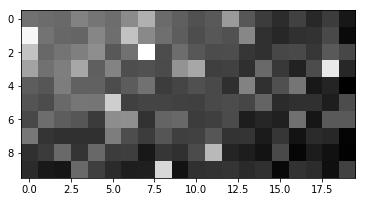

In [110]:
# I set up a matrix full of values, with some order (in order to be predictable)
N, T = (10, 20)
Yreal = np.array([[np.random.exponential(scale = 3, size = 1)[0] + ((T-j)**0.5)*np.log(N-i+1) for j in np.arange(T)] for i in np.arange(N)])
print(Yreal)
plt.imshow(Yreal, cmap=plt.cm.gray);

In [111]:
# specifying the units treated, and the earliest time of treatment
tr_units = np.arange(int(N/3),N)
t0 = int(T/2)

[[11.10328107 10.6648671  10.57180318 12.44890752 11.39709621 10.73603842
  13.21498354 16.19970787 10.61622969  9.66535008  8.55253032  9.1258884
  14.40253861  9.01607998  6.94348485  5.51480246  7.28822193  5.23866253
   6.90079247  3.88965889]
 [21.88890948 11.26072961 10.29541941 10.1286228  12.79766947 10.82702714
  17.6122818  13.06012541 10.97316879  9.5206277   8.21511212  9.00004526
   8.55465696 12.82918008  5.91122296  5.18522737  5.89082523  6.06316366
   7.98973347  2.85037117]
 [17.77563759 10.34620198 11.35326824 12.25000737 13.44681873  9.0891511
  11.15909003 22.55299747  8.10691117 10.79262544  9.02163773  8.12702123
   8.22280831  6.35291672  5.84053829  7.72387347  7.85128493  6.46203566
   9.22707783  7.7270509 ]
 [15.2147294  11.2093389  12.14782555 15.44723685  9.64785691 12.5062235
   8.29841629  8.53004749  8.04697099 13.92129237 15.43161333  7.03545896
   7.21498055  5.82608469 10.53379929  6.52167672  4.75697224  8.11821437
  20.78094771         nan]
 [ 9.52

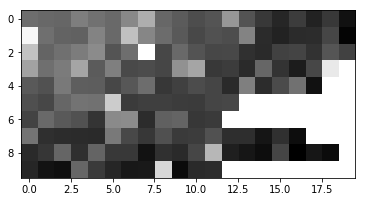

In [112]:
Yobs = stag_adopt(Yreal, tr_units, t0)

print(Yobs)
plt.imshow(Yobs, cmap=plt.cm.gray);

Iteration 1	 Current loss: 1.556848317504585
Iteration 20	 Current loss: 0.006358421149145352
Iteration 40	 Current loss: 1.0369413036351632e-05

Final values:
Iteration 48	 Current loss: 7.934622625365779e-07

[[11.10328107 10.6648671  10.57180318 12.44890752 11.39709621 10.73603842
  13.21498354 16.19970787 10.61622969  9.66535008  8.55253032  9.1258884
  14.40253861  9.01607998  6.94348485  5.51480246  7.28822193  5.23866253
   6.90079247  3.88965889]
 [21.88890948 11.26072961 10.29541941 10.1286228  12.79766947 10.82702714
  17.6122818  13.06012541 10.97316879  9.5206277   8.21511212  9.00004526
   8.55465696 12.82918008  5.91122296  5.18522737  5.89082523  6.06316366
   7.98973347  2.85037117]
 [17.77563759 10.34620198 11.35326824 12.25000737 13.44681873  9.0891511
  11.15909003 22.55299747  8.10691117 10.79262544  9.02163773  8.12702123
   8.22280831  6.35291672  5.84053829  7.72387347  7.85128493  6.46203566
   9.22707783  7.7270509 ]
 [15.2147294  11.2093389  12.14782555 15.447

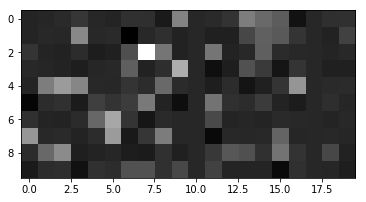

In [113]:
# getting the treat unit-times
observedset = np.argwhere(~np.isnan(Yobs))
o_idx = np.random.choice(list(range(observedset.shape[0])), size = int(observedset.shape[0]/5), replace=False)

# Initializing the MC-NNM object
my_mcnnm = MatrixCompletion_NNM(setOk=tuple(observedset[o_idx].T), 
                                lamb=10, epsilon=10**(-6), doprint=True, max_iters=200, printbatch=20)

# Fitting (/transforming)
Lest = my_mcnnm.fit_transform(Yobs)

print(Lest)
plt.imshow(Lest, cmap=plt.cm.gray);

In [115]:
# total loss on the full sample
mcnnm_loss(Yreal, Lest, tuple(observedset.T))

8.669331008634215

In [116]:
U, Sigma, VT = np.linalg.svd(Lest, full_matrices=False)
print(Sigma)
print(np.median(Sigma))

[2.97205741e+01 2.62459518e+01 2.18879134e+01 2.14571653e+01
 1.61319666e+01 1.45697133e+01 1.29247231e+01 2.12134359e-15
 1.54409409e-15 7.58049933e-16]
15.350839929591562


## Cross-validation

The typical strategy of cross-validation is to split the rows of the data (X,y) to have specific folds (X_k, y_k) which are used to fit the model, and are then evaluated on the left-out fold (X_k', y_k').

In this case, it is a bit different, because the prediction is the matrix itself.

The approximation, and as a consequence the estimate, will depend on the value of $\lambda$. As a hyper-parameter, we will choose its value through cross-validation.

Athey et al. propose to use some sort of $K$-fold cross-validation, and choose $K$ such that 
$$\left|\mathcal{O}_k\right|/\left|\mathcal{O}\right| = \left|\mathcal{O}\right|/(NT).$$
That is, such that the fraction of non-missing values in a given validation set $\mathcal{O}_k$ is equal to the fraction of non-missing values in the original matrix. We will do this making use of Grid Search. 

This obviously assumes that we have access to the real matrix in which we can actually observe the supposed ''missing'' values. 

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [193]:
def mcnnm_kfold_CV(Yreal, Yobs, observedset, lambda_cv, num_splits=10):
    kfold = KFold(n_splits=num_splits, shuffle=True)
    vec_errors = np.zeros(num_splits)
    for i, train_test_tuple in enumerate(kfold.split(observedset)):
        O_train_i = tuple(observedset[train_test_tuple[0]].T)
        O_valid_i = tuple(observedset[train_test_tuple[1]].T)

        # Initializing the MC-NNM object
        my_mcnnm_i = MatrixCompletion_NNM(setOk=O_train_i, 
                                    lamb=lambda_cv, epsilon=10**(-6))

        # Fitting (/transforming)
        Lest = my_mcnnm_i.fit_transform(Yobs)

        # Error on validation set
        vec_errors[i] = mcnnm_loss(Yreal, Lest, O_valid_i)
        
    return vec_errors

def mcnnm_GridSearch(Yreal, Yobs, observedset, lambda_vec, num_splits=10, doprint=True):
    mat_errors = np.zeros((len(lambda_vec), num_splits))
    for i, lambda_cv in enumerate(lambda_vec):
        mat_errors[i,:] = mcnnm_kfold_CV(Yreal, Yobs, observedset, lambda_cv, num_splits=num_splits)
    
    
    
    df_results = pd.DataFrame(mat_errors,
                             index = ["Lambda = {}".format(np.round(l, 2)) for l in lambda_vec],
                             columns = ["Fold {}".format(i+1) for i in range(num_splits)])
    
    vec_rmse = df_results.mean(axis=1)
    best_lambda = lambda_vec[np.argmin(np.array(vec_rmse))]
    
    if doprint:
        print("\nMatrix of errors:")
        print("-----------------")
        print(df_results)
        print("\nAverage RMSE across folds:")
        print("--------------------------")
        print(vec_rmse)
        print("\nBest parameter value (returned):")
        print("--------------------------------")
        print(np.round(best_lambda, 3))
    
    return best_lambda
    


Lambda vector:[  1.1         31.56896552  62.03793103  92.50689655 122.97586207
 153.44482759 183.9137931  214.38275862 244.85172414 275.32068966
 305.78965517 336.25862069 366.72758621 397.19655172 427.66551724
 458.13448276 488.60344828 519.07241379 549.54137931 580.01034483
 610.47931034 640.94827586 671.41724138 701.8862069  732.35517241
 762.82413793 793.29310345 823.76206897 854.23103448 884.7       ]


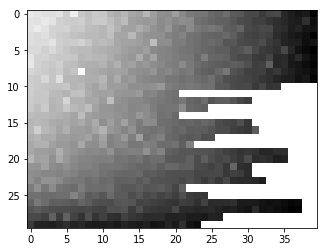

In [194]:
# Creating my data
N, T = (30, 40)
Yreal = np.array([[np.random.exponential(scale = 2, size = 1)[0] + ((T-j)**0.75)*np.log(N-i+1) for j in np.arange(T)] for i in np.arange(N)])

# specifying the units treated, and the earliest time of treatment
tr_units = np.arange(int(N/3),N)
t0 = int(T/2)

# -------------------------------------------
Yobs = stag_adopt(Yreal, tr_units, t0)
plt.imshow(Yobs, cmap=plt.cm.gray);

observedset = np.argwhere(~np.isnan(Yobs))

# Specifying a set of values for lambda from a SVD on the Yobs with missing=0
U, Sigma, VT = np.linalg.svd(PO_operator(Yobs, tuple(observedset.T)), full_matrices=False)
lambda_values = np.linspace(1.1*np.min(np.floor(Sigma[Sigma>0])),
                            0.9*np.max(np.floor(Sigma[Sigma>0])), 
                            num=30)
print("Lambda vector:{}".format(lambda_values))

# Creating GridSearchCV-type objects
tuned_parameters = [{'lamb': lambda_values}]
n_folds = 5
myfunction_loss = make_scorer(loss, setO=tuple(observedset.T), greater_is_better=False) # I don't use this...


In [195]:
best_lamb = mcnnm_GridSearch(Yreal, Yobs, observedset, lambda_values, num_splits=n_folds, doprint=False)

In [196]:
# Initializing the MC-NNM object
my_mcnnm = MatrixCompletion_NNM(setOk=tuple(observedset.T), 
                                lamb=best_lamb, # <------ best value!
                                epsilon=10**(-6), doprint=True, max_iters=200, printbatch=20)

# Fitting (/transforming)
Lest = my_mcnnm.fit_transform(Yobs)

# total loss on the full sample
mcnnm_loss(Yreal, Lest, tuple(observedset.T))

Iteration 1	 Current loss: 3.2945698893333275
Iteration 20	 Current loss: 1.8940034928867089
Iteration 40	 Current loss: 1.8940034928841394
Iteration 60	 Current loss: 1.8940034928841392
Iteration 80	 Current loss: 1.8940034928841392
Iteration 100	 Current loss: 1.8940034928841392
Iteration 120	 Current loss: 1.8940034928841392
Iteration 140	 Current loss: 1.8940034928841392
Iteration 160	 Current loss: 1.8940034928841392
Iteration 180	 Current loss: 1.8940034928841392
Iteration 200	 Current loss: 1.8940034928841392

Final values:
Iteration 200	 Current loss: 1.8940034928841392

[[55.39912753 54.59487507 53.44175332 ...  8.24696806  9.44388875
   4.24279375]
 [54.58323038 53.59248932 55.40833455 ...  9.74931152 14.0394379
   6.42703165]
 [54.2316932  56.06311479 54.26878396 ... 11.7848737   8.19022058
   7.35675704]
 ...
 [22.21878438 24.02347    22.26868028 ...  4.40378018         nan
          nan]
 [19.78547952 19.84341188 18.23522072 ...         nan         nan
          nan]
 [16.

1.8940034928841392

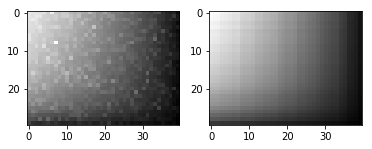

In [197]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.imshow(Yreal, cmap=plt.cm.gray)
ax1.imshow(Lest, cmap=plt.cm.gray)
plt.show()